<a href="https://colab.research.google.com/github/mharalampopoulos2/FINALCISC5800/blob/main/Machine_Learning_Final_NO_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing from files - files will be provided in submission to replicate
import google.colab.files as files

uploaded = files.upload()


Saving Ad_Click_prediciton_test.csv to Ad_Click_prediciton_test.csv
Saving Ad_click_prediction_train (1).csv to Ad_click_prediction_train (1).csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import roc_auc_score, log_loss, roc_curve, accuracy_score, precision_score, recall_score, f1_score

#file handling
uploaded_files = list(uploaded.keys())
print("Uploaded files:", uploaded_files)

#manual config
TRAIN_PATH = uploaded_files[1]
TEST_PATH = uploaded_files[0]

#config
RANDOM_STATE = 42
TEST_SIZE = 0.2

Uploaded files: ['Ad_Click_prediciton_test.csv', 'Ad_click_prediction_train (1).csv']


In [3]:
#read in and display sets - sanity check
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print("Training set:")
display(train_df.head())

Train shape: (463291, 15)
Test shape: (128858, 14)
Training set:


,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0


In [4]:
#check class balance values
print("Class balance:")
display(train_df["is_click"].value_counts(normalize=True))

#top 10 missingness to see if anything needs to be removed
print("Missingness (top 10):")
display(train_df.isna().mean().sort_values(ascending=False).head(10))

#drop features with high numbers of missing values
train_df.drop(["product_category_2", "city_development_index"], inplace=True, axis=1)
test_df.drop(["product_category_2", "city_development_index"], inplace=True, axis=1)

display(train_df.isna().mean().sort_values(ascending=False).head(10))

num_cols = train_df.drop(columns=["is_click"]).select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in train_df.drop(columns=["is_click"]).columns if c not in num_cols]

#sanity check
print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))


Class balance:


,proportion
is_click,
0,0.932373
1,0.067627


Missingness (top 10):


,0
product_category_2,0.789685
city_development_index,0.270087
gender,0.039377
user_group_id,0.039377
age_level,0.039377
user_depth,0.039377
session_id,0.000000
product_category_1,0.000000
webpage_id,0.000000
campaign_id,0.000000


,0
gender,0.039377
age_level,0.039377
user_depth,0.039377
user_group_id,0.039377
session_id,0.000000
campaign_id,0.000000
product,0.000000
user_id,0.000000
DateTime,0.000000
webpage_id,0.000000


Numeric features: 9
Categorical features: 3


In [5]:
#drop any missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

#separate features from target to predict later on
y = train_df["is_click"]
X = train_df.drop(columns=["is_click"])

In [6]:
#just in case we neeed to handle any string values in our predictions
#converting prediction set into binary feature
def coerceBinary(y):
    if y.dtype != object:
        return y.astype(int)
    return y.astype(str).str.lower().map({
        "1":1, "0":0, "yes":1, "no":0, "true":1, "false":0
    })

y = coerceBinary(y)

#pipeline creation
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

In [7]:
#sanity check
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Train Head:", X_train.head())

Train shape: (356038, 12)
Validation shape: (89010, 12)
Train Head:         session_id          DateTime  user_id product  campaign_id  \
189608      544258  2017-07-04 13:23   571301       I        82320   
238275      508731  2017-07-05 05:57   551046       H       405490   
420353      199073  2017-07-07 10:11   129492       I       118601   
169870      446655  2017-07-04 08:01    63548       H       360936   
57869        28810  2017-07-02 18:12   295030       B       360936   

        webpage_id  product_category_1  user_group_id gender  age_level  \
189608        1734                   1            2.0   Male        2.0   
238275       60305                   3            2.0   Male        2.0   
420353       28529                   4            2.0   Male        2.0   
169870       13787                   3            4.0   Male        4.0   
57869        13787                   2            1.0   Male        1.0   

        user_depth  var_1  
189608         3.0      1  
2382

In [12]:
#model creation for all 3 models
class_weights = y.value_counts(normalize=True).to_dict()
print("Class weights:", class_weights)

models = {
    "Logistic (L2)": LogisticRegression(
    max_iter=500,
    class_weight=class_weights
    ),

    "Logistic (L1 / Lasso)": LogisticRegression(
    penalty="l1",
    solver="liblinear",
    class_weight=class_weights,
    max_iter=200

    ),

    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        max_iter=30,
        early_stopping=True,
        random_state=RANDOM_STATE,
        batch_size=int((0.005*len(X_train))//1),
        alpha=0.01,
        learning_rate_init=0.001,
        learning_rate="adaptive",
        activation="relu",
        verbose=1
    )
}

#create pipelines for easy and streamlined training process
pipelines = {
    name: Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])
    for name, model in models.items()
}

Class weights: {0: 0.9324634646150528, 1: 0.06753653538494724}


In [16]:
#L2
%%time
#just for logging time due to problems early on

pipe_log_l2 = pipelines["Logistic (L2)"]
pipe_log_l2.fit(X_train, y_train)

probs_l2 = pipe_log_l2.predict_proba(X_val)[:, 1]

auc_l2 = roc_auc_score(y_val, probs_l2)
ll_l2 = log_loss(y_val, probs_l2)

print("Logistic (L2)")
print("AUC:", auc_l2)
print("LogLoss:", ll_l2)

Logistic (L2)
AUC: 0.5531228086283634
LogLoss: 0.3586642305185065
CPU times: user 3.35 s, sys: 75.5 ms, total: 3.43 s
Wall time: 3.45 s


In [17]:
#L1
%%time

pipe_log_l1 = pipelines["Logistic (L1 / Lasso)"]
pipe_log_l1.fit(X_train, y_train)

probs_l1 = pipe_log_l1.predict_proba(X_val)[:, 1]

auc_l1 = roc_auc_score(y_val, probs_l1)
ll_l1 = log_loss(y_val, probs_l1)

print("Logistic (L1 / Lasso)")
print("AUC:", auc_l1)
print("LogLoss:", ll_l1)


Logistic (L1 / Lasso)
AUC: 0.5602779559377951
LogLoss: 0.3582625714720075
CPU times: user 18.7 s, sys: 226 ms, total: 19 s
Wall time: 21.3 s


In [18]:
#mlp
%%time

pipe_nn = pipelines["Neural Network"]
pipe_nn.fit(X_train, y_train)

probs_nn = pipe_nn.predict_proba(X_val)[:, 1]

auc_nn = roc_auc_score(y_val, probs_nn)
ll_nn = log_loss(y_val, probs_nn)

print("Neural Network")
print("AUC:", auc_nn)
print("LogLoss:", ll_nn)

Iteration 1, loss = 0.27759432
Validation score: 0.932451
Iteration 2, loss = 0.24139933
Validation score: 0.932451
Iteration 3, loss = 0.23626842
Validation score: 0.932451
Iteration 4, loss = 0.22631147
Validation score: 0.932451
Iteration 5, loss = 0.20619644
Validation score: 0.932255
Iteration 6, loss = 0.17812463
Validation score: 0.923941
Iteration 7, loss = 0.15132880
Validation score: 0.918211
Iteration 8, loss = 0.12908992
Validation score: 0.895208
Iteration 9, loss = 0.11271254
Validation score: 0.910319
Iteration 10, loss = 0.09558063
Validation score: 0.906808
Iteration 11, loss = 0.08374658
Validation score: 0.902230
Iteration 12, loss = 0.07364651
Validation score: 0.892765
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Neural Network
AUC: 0.5450439019606519
LogLoss: 0.24701808364229075
CPU times: user 3min 48s, sys: 1.31 s, total: 3min 49s
Wall time: 2min 16s


,Model,AUC,LogLoss
1,Logistic (L1 / Lasso),0.560278,0.358263
0,Logistic (L2),0.553123,0.358664
2,Neural Network,0.545044,0.247018


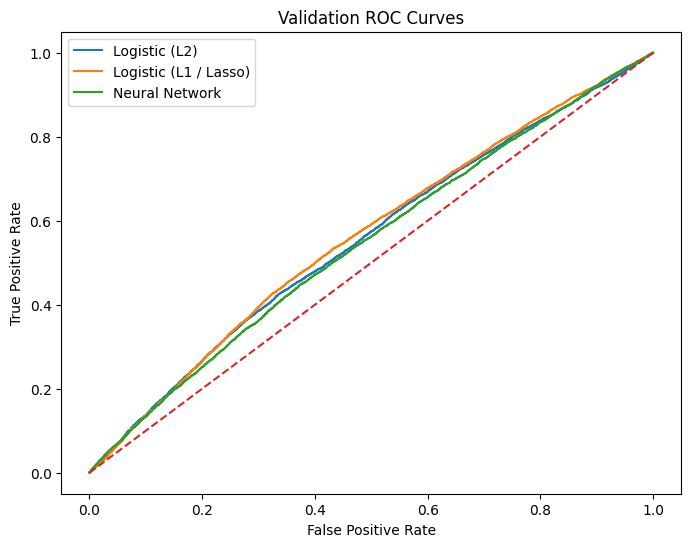

In [19]:
#final results and roc curve graph (SMOTE applied)
results_df = pd.DataFrame([
    {"Model": "Logistic (L2)", "AUC": auc_l2, "LogLoss": ll_l2},
    {"Model": "Logistic (L1 / Lasso)", "AUC": auc_l1, "LogLoss": ll_l1},
    {"Model": "Neural Network", "AUC": auc_nn, "LogLoss": ll_nn}
]).sort_values("AUC", ascending=False)

display(results_df)

plt.figure(figsize=(8,6))

fpr, tpr, _ = roc_curve(y_val, probs_l2)
plt.plot(fpr, tpr, label="Logistic (L2)")

fpr, tpr, _ = roc_curve(y_val, probs_l1)
plt.plot(fpr, tpr, label="Logistic (L1 / Lasso)")

fpr, tpr, _ = roc_curve(y_val, probs_nn)
plt.plot(fpr, tpr, label="Neural Network")

plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curves")
plt.legend()
plt.show()

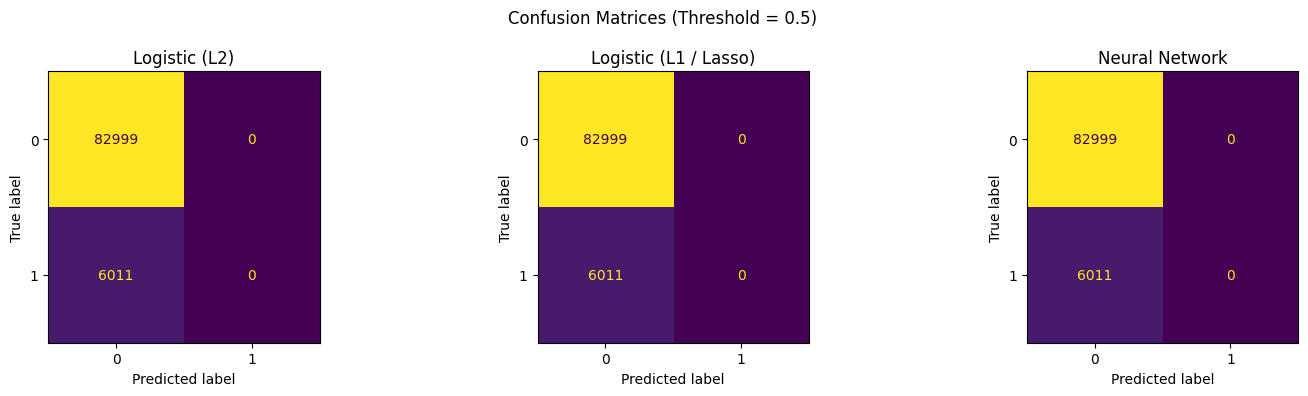

In [22]:
#confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

THRESHOLD = 0.5

log_l2 = pipelines["Logistic (L2)"]
log_l1 = pipelines["Logistic (L1 / Lasso)"]
mlp = pipelines["Neural Network"]

models_for_cm = {
    "Logistic (L2)": log_l2,
    "Logistic (L1 / Lasso)": log_l1,
    "Neural Network": mlp
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, model) in zip(axes, models_for_cm.items()):
  probs = model.predict_proba(X_val)[:, 1]
  preds = (probs >= THRESHOLD).astype(int)

  cm = confusion_matrix(y_val, preds)
  disp = ConfusionMatrixDisplay(cm)

  disp.plot(ax=ax, colorbar=False)
  ax.set_title(name)

plt.suptitle("Confusion Matrices (Threshold = 0.5)")
plt.tight_layout()
plt.show()

In [30]:
#test dataset predictions - done separately from other work due to previous mistake in splitting data
#test dataset not used for other analyses due to lack of target variable 'is_click'

test_predictions = pd.DataFrame({
    "session_id": test_df["session_id"],
    "Logistic_L2_prob": log_l2.predict_proba(test_df)[:, 1],
    "Logistic_L1_prob": pipe_log_l1.predict_proba(test_df)[:, 1],
    "Neural_Net_prob": pipe_nn.predict_proba(test_df)[:, 1]
})

display(test_predictions.head())

,session_id,Logistic_L2_prob,Logistic_L1_prob,Neural_Net_prob
0,411705,0.006782,0.006854,0.112927
3,547761,0.004865,0.003360,0.048811
4,574275,0.006636,0.006583,0.073745
5,394913,0.005193,0.005520,0.081868
6,562747,0.005930,0.006789,0.104340
